In [377]:
import numpy as np
import torch
import math
import importlib
# import socialSigLayers
# importlib.reload(socialSigLayers)
import pandas as pd
import random
import matplotlib.pyplot as plt

In [378]:
class bilinearImputation(torch.nn.Module):
    '''
    Class to create the social signature image
    '''
    def __init__(self, X):
        super(bilinearImputation, self).__init__()
        self.W = torch.nn.Parameter(torch.tensor(np.arange(0,X.shape[1]), dtype = torch.float32, requires_grad=True))
        self.outDim = [10,10]
        self.inDim = math.ceil(math.sqrt(X.shape[1]))

    def forward(self, batchX):
        
        # print("    W at beginning: ", torch.tensor(self.W, dtype = torch.int)) 
        print("    W at beginning: ", self.W) 

        self.X = batchX
        xTemp = torch.stack([self.X, self.W.clone().repeat(self.X.shape[0],1).data])
        XSort, indices = torch.sort(xTemp, dim=1, descending=False)

        
        inDataSize = XSort[0].shape[1] #Data we have per dimension
        targetSize = self.inDim ** 2
        paddingOffset = targetSize - inDataSize
        paddedInX = torch.nn.functional.pad(input=XSort[0], pad=(0,paddingOffset), mode="constant", value=0)
        buildImage = torch.reshape(paddedInX,(self.X.shape[0], 1, self.inDim, self.inDim))   
        return torch.nn.functional.interpolate(buildImage, size=([self.outDim[0], self.outDim[1]]), mode='bilinear')

In [379]:
###### Define our model
class SocialSigNet(torch.nn.Module):
    def __init__(self, X):
        super().__init__()
        self.SocialSig = bilinearImputation(X=X)                
        self.conv2d = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxPool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)#,
            # torch.nn.Sequential(
            #     torch.nn.Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False),
            #     torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            # )
        )
        self.block3 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.seqBlock1 = torch.nn.Sequential(self.block1, self.block1)
        self.seqBlock2 = torch.nn.Sequential(self.block2, self.block3)
    

        self.block4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            #   (downsample): Sequential(
            #     (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
            #     (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            #   )
        )
        self.block5 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.seqBlock3 = torch.nn.Sequential(self.block4, self.block5)

        self.block6 = torch.nn.Sequential(
                torch.nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
                torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            #   (downsample): Sequential(
            #     (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
            #     (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            #   )
            )
        self.block7 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

        self.seqBlock4 = torch.nn.Sequential(self.block6, self.block7)

        self.linear = torch.nn.Linear(51200, 100)

        
    def forward(self, X, epoch):
        out = self.SocialSig(X) # OUT:  torch.Size([100, 1, 10, 10])

        # print(out)
        # tmp = out.clone()
        # print('SHAPE: ', tmp[0].flatten().shape)
        pd.DataFrame(out.clone()[0].flatten()).to_csv("./figs/im" + str(epoch) + ".csv")

        out = self.conv2d(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxPool(out)
        out = self.seqBlock1(out)
        out = self.seqBlock2(out)
        out = self.seqBlock3(out)
        out = self.seqBlock4(out)
        out = self.relu(out)
        out = out.flatten()
        out = self.linear(out)
        # print("OUT: ", out.shape)
        # print("OUT: ", out)
        return out

In [380]:
####### Load our Data
from sklearn import preprocessing
devSet = pd.read_csv("us_migration.csv")
devSet = devSet.loc[:, ~devSet.columns.str.contains('^Unnamed')]
devSet = devSet.apply(lambda x: pd.to_numeric(x, errors='coerce'))
devSet = devSet.dropna(axis=1)

y = torch.Tensor(devSet['US_MIG_05_10'].values)
X = devSet.loc[:, devSet.columns != "US_MIG_05_10"].values

mMScale = preprocessing.MinMaxScaler()
X = mMScale.fit_transform(X)


In [381]:
#y - 'number_moved'
#x - 'everything else that is or can be represented as a float.'

####### Build and fit the Model
model = SocialSigNet(X=X)
lr = 1e-6
batchSize = 100

In [382]:
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

In [383]:
def update_function(param, grad, loss, learning_rate):
    # print(grad.mean(axis = 1))
    return param - learning_rate * grad.mean(axis = 0)[0]


def mae(real, pred):
    return torch.abs(real - pred).mean()

In [384]:
for t in range(20):
    #Batches
    # batchObs = random.sample(range(0, len(y)), batchSize)
    batchObs = [i for i in range(0, 100)]
    modelX = X[batchObs]
    # print(modelX.shape)
    modelX = torch.tensor(list(modelX), requires_grad = True, dtype = torch.float32)
    modely = torch.tensor(y[batchObs], dtype = torch.float32)  # MADE A CHANGE HERE 
    
    
    print("EPOCH: ", t)
    y_pred = model(modelX, t)
    # print(y_pred)
    loss = criterion(y_pred, modely)  
    # print()  
    print("    Loss:     ", loss.item(), "     MAE: ", mae(y_pred, modely).item())
    
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    grad = torch.autograd.grad(outputs=loss, inputs=modelX, retain_graph = True)
    # print("    GRADIENT: ", grad[0][0].shape)
    # print("    GRADIENT: ", grad)
    loss.backward()
    optimizer.step()
    # https://discuss.pytorch.org/t/updatation-of-parameters-without-using-optimizer-step/34244/4
    with torch.no_grad():
        for p in model.parameters():
            # print("    In with:        ", p.data)
            new_val = update_function(p, grad[0], loss, lr)
            # print("NEW WEIGHTS: ", new_val)
            p.copy_(new_val)
    
    print("\n")

EPOCH:  0
    W at beginning:  Parameter containing:
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29.], requires_grad=True)
tensor([[0.2898, 0.1509, 0.0190,  ..., 0.1573, 0.1314, 0.0966],
        [0.2899, 0.1219, 0.0467,  ..., 0.1205, 0.0576, 0.1563],
        [0.2899, 0.0849, 0.0434,  ..., 0.0958, 0.0000, 0.0581],
        ...,
        [0.3544, 0.1835, 0.0631,  ..., 0.1078, 1.0000, 0.0559],
        [0.3544, 0.1527, 0.0137,  ..., 0.1609, 0.0822, 0.1063],
        [0.3545, 0.0551, 0.0601,  ..., 0.0545, 0.1000, 0.0278]],
       grad_fn=<SelectBackward>)
    Loss:      107695616.0      MAE:  732.6861572265625


EPOCH:  1
    W at beginning:  Parameter containing:
tensor([4.4054e-04, 1.0004e+00, 2.0004e+00, 3.0004e+00, 4.0004e+00, 5.0004e+00,
        6.0004e+00, 7.0004e+00, 8.0004e+00, 9.0004e+00, 1.0000e+01, 1.1000e+01,
        1.2000e+01, 1.3000e+01, 1.4000e+01, 1.5000

In [385]:
y_pred

tensor([-0.1735, -0.2011, -0.1756, -0.1974, -0.1698, -0.1929, -0.2003, -0.1969,
        -0.2097, -0.1358, -0.2016, -0.2019, -0.1959, -0.1927, -0.1798, -0.1978,
        -0.1887, -0.1976, -0.2014, -0.1940, -0.1928, -0.1872, -0.2041, -0.1832,
        -0.2051, -0.2015, -0.2017, -0.2099, -0.2004, -0.1937, -0.1982, -0.1738,
        -0.1959, -0.1914, -0.1941, -0.2033, -0.2000, -0.2033, -0.2012, -0.2023,
        -0.1967, -0.2017, -0.1936, -0.1774, -0.1942, -0.1984, -0.1822, -0.1529,
        -0.1442, -0.1627, -0.1926, -0.1968, -0.1772, -0.1567, -0.1723, -0.1866,
        -0.1679, -0.1798, -0.1608, -0.1117, -0.1890, -0.1612, -0.1749, -0.1954,
        -0.1441, -0.1364, -0.1941, -0.1715, -0.1929, -0.1890, -0.1848, -0.1864,
        -0.1797, -0.1961, -0.1444, -0.1394, -0.1523, -0.1873, -0.1710, -0.1721,
        -0.1860, -0.1787, -0.1713, -0.1899, -0.1755, -0.1787, -0.2040, -0.1528,
        -0.1877, -0.1954, -0.1753, -0.1862, -0.1675, -0.0787, -0.1842, -0.0269,
        -0.1935, -0.1968, -0.1899, -0.19

In [386]:
modely

tensor([ 961.,  154.,  905.,  225., 1071.,  337.,  204.,  320.,   61., 2063.,
         125.,  170.,  378.,  318.,  777.,  201.,  427.,  187.,  133.,  304.,
         479.,  464.,  163.,  772.,   57.,  219.,  211.,   80.,  267.,  307.,
         198., 1048.,  229.,  413.,  460.,  121.,  255.,  147.,  136.,  157.,
         268.,  295.,  342.,  780.,  494.,  222.,  802., 1507., 1634., 1183.,
         522.,  281.,  943., 1354.,  984.,  619., 1175.,  897., 1201., 2672.,
         568., 1363.,  830.,  436., 1862., 2042.,  350.,  951.,  481.,  556.,
         592.,  515.,  694.,  344., 1777., 1974., 1581.,  519., 1025., 1053.,
         719.,  708., 1072.,  440.,  861.,  723.,  138., 1419.,  542.,  287.,
         996.,  511., 1119., 3623.,  567., 4955.,  500.,  278.,  392.,  225.])

In [387]:
print("Model.parameters")
print(model.parameters)
print("SSParam")
print(list(model.SocialSig.parameters()))
print("is_leaf")
print(list(model.SocialSig.parameters())[0].is_leaf)
print("gradfn")
print(list(model.SocialSig.parameters())[0].grad_fn)
print("Grad")
print(list(model.SocialSig.parameters())[0].grad)

Model.parameters
<bound method Module.parameters of SocialSigNet(
  (SocialSig): bilinearImputation()
  (conv2d): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxPool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (block1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [388]:
def show_image(best_epoch):
    df = pd.read_csv("./figs/im" + str(best_epoch) + ".csv")
    df["0"] = df["0"].str.split("(").str[1].str.split(",").str[0].astype(float)
    plt.imshow(np.reshape(np.array(df["0"]), (10, 10)))

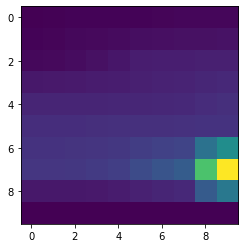

In [389]:
show_image(10)

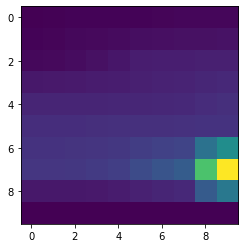

In [390]:
show_image(0)

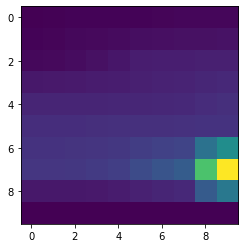

In [391]:
show_image(99)